# Model Training - Eren Jaeger - Season 4

## Import libraries

In [51]:
!pip install albumentations

In [52]:
import numpy as np

# Set seed for reproducibility
seed = np.random.randint(0, 1000000)
print(f"The seed is: {seed}")

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.utils import register_keras_serializable

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import IPython.display as display

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The seed is: 725613
2.16.1


## Preparations

In [53]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [54]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [55]:
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


## Data Preparation

In [56]:
# Set batch size for training
BATCH_SIZE = 32
if numTPU != 0:
    BATCH_SIZE = strategy.num_replicas_in_sync * 32

print(f"Batch size: {BATCH_SIZE}")

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 100

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

Batch size: 32


In [70]:
dataset_path = '/kaggle/input/new-marssoil/clean_mars.npz'
data = np.load(dataset_path)
X = data["X_train"]
y = data["y_train"]

X = np.expand_dims(X, axis=-1)

In [71]:
X.shape, y.shape

((2505, 64, 128, 1), (2505, 64, 128))

In [72]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


In [73]:
# Set steps per epoch for training
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [74]:
# Define the category mapping
category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4,  # Big Rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [75]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [76]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [77]:
def one_hot_encode_mask(mask, num_classes):
    """
    Converts a segmentation mask into a one-hot encoded tensor.
    
    Parameters:
    - mask (tf.Tensor): Input mask of shape (H, W) with class indices.
    - num_classes (int): Number of classes for one-hot encoding.
    
    Returns:
    - tf.Tensor: One-hot encoded mask of shape (H, W, num_classes).
    """
    if not isinstance(mask, tf.Tensor):
        mask = tf.convert_to_tensor(mask)
    
    # Create one-hot encoded tensor
    one_hot_mask = tf.one_hot(mask, depth=num_classes)
    
    return one_hot_mask

In [78]:
original_height = X_train[0].shape[0]
original_width = X_train[0].shape[1]

def augment_dataset(X, y, augmentations_per_image):
    X_augmented = []
    y_augmented = []

    aug = A.Compose([
        A.OneOf([
            A.RandomSizedCrop(min_max_height=(30, 50), height=original_height, width=original_width, p=0.8),
            A.VerticalFlip(p=0.8),
        ],p=1),
    ])

    for _ in range(augmentations_per_image):
        for image, mask in zip(X, y):
            augmented = aug(image=image, mask=mask)
            X_augmented.append(augmented['image'])
            y_augmented.append(augmented['mask'])
    
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    X_combined = np.concatenate((X, X_augmented), axis=0)
    y_combined = np.concatenate((y, y_augmented), axis=0)

    return X_combined, y_combined

In [79]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    if augment:
        image_paths, label_paths = augment_dataset(image_paths, label_paths, 1)

    
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths)).cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # One hot encode mask
    dataset = dataset.map(
        lambda x, y: (x, one_hot_encode_mask(y, NUM_CLASSES)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [80]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 5)
Labels dtype: <dtype: 'float32'>


Visualizing examples from the training set:


TypeError: Invalid shape (64, 128, 5, 4) for image data

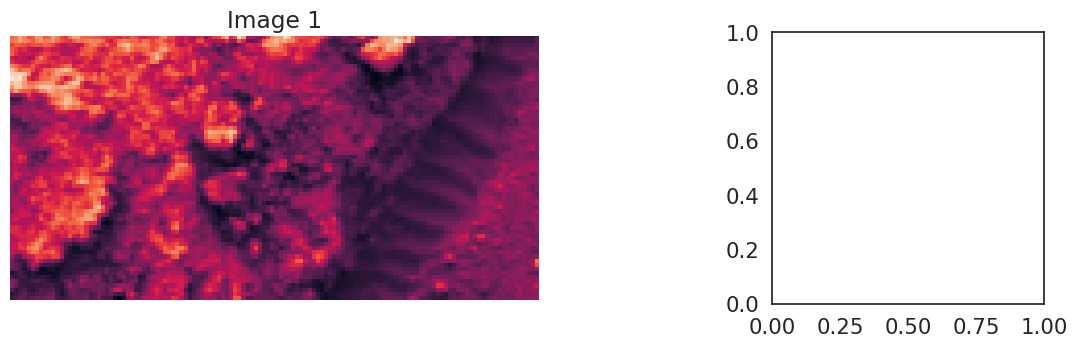

In [81]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Model

In [ ]:
def unet_block(input_tensor, filters, kernel_size=6, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [82]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │     1,184 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,896 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_2   │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,792 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,520 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_3   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │   295,040 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 1,884,581 (7.19 MB)

 Trainable params: 1,883,301 (7.18 MB)

 Non-trainable params: 1,280 (5.00 KB)

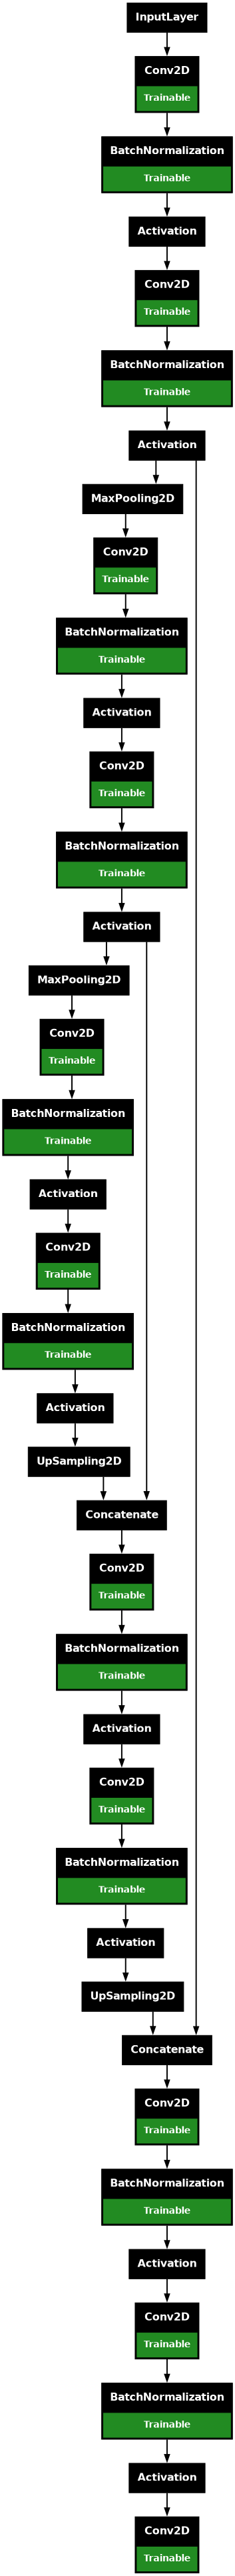

In [83]:
with strategy.scope():
    model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [84]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)


        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5, output_dir='visualizations'):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            # Prepare directory for saving images
            epoch_dir = os.path.join(self.output_dir, f"Epoch{epoch}")
            os.makedirs(epoch_dir, exist_ok=True)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')
            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')
            predicted_mask_path = os.path.join(epoch_dir, "predicted_mask.png")
            plt.savefig(predicted_mask_path)

            plt.tight_layout()
            plt.show()
            plt.close()

# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['mean_iou'])
        self.val_acc.append(logs['val_mean_iou'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Mean IOU')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Mean IOU')
        self.ax_acc.set_title('Training and Validation Mean IOU')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Mean IOU')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [85]:
class GeneralizedDiceLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        # Ensure y_pred is normalized (softmax output)
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        
        # Compute weights
        weights = 1.0 / (tf.reduce_sum(y_true, axis=[0, 1, 2])**2 + 1e-9)
        
        # Compute numerator
        numerator = tf.reduce_sum(weights * tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2]))
        
        # Compute denominator
        denominator = tf.reduce_sum(weights * tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2]))
        
        # Compute Generalized Dice coefficient
        dice = 2.0 * (numerator + 1e-9) / (denominator + 1e-9)
        
        # Return Generalized Dice loss
        return 1.0 - dice

In [86]:
def weighted_categorical_crossentropy(weights):
    def wcce(y_true, y_pred):
        Kweights = tf.constant(weights, dtype=tf.float32)
        if not tf.is_tensor(y_pred): y_pred = tf.constant(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.categorical_crossentropy(y_true, y_pred) * tf.sum(y_true * Kweights, axis=-1)
    return wcce


def weighted_categorical_crossentropy(weights):
    # weights = [0.9, 0.05, 0.04, 0.01]
    weights = tf.constant(weights, dtype=tf.float32)
    
    def wcce(y_true, y_pred):
        # Ensure y_pred is a tensor and dtype matches
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Compute the standard categorical cross-entropy
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
        # Apply weights to the true labels
        weighted_sum = tf.reduce_sum(y_true * weights, axis=-1)
        
        # Return the weighted loss
        return cce * weighted_sum
    return wcce

In [93]:
l2_lambda = 5e-2

weights = [0.1,0.05,0.15,0.2,0.5]

# Compile the model
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=weighted_categorical_crossentropy(weights),
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,  weight_decay=l2_lambda),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )
print("Model compiled!")

Compiling model...
Model compiled!


In [94]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_loss",
                                            factor=0.5,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0,
                                        )

plot_callback = RealTimePlot()

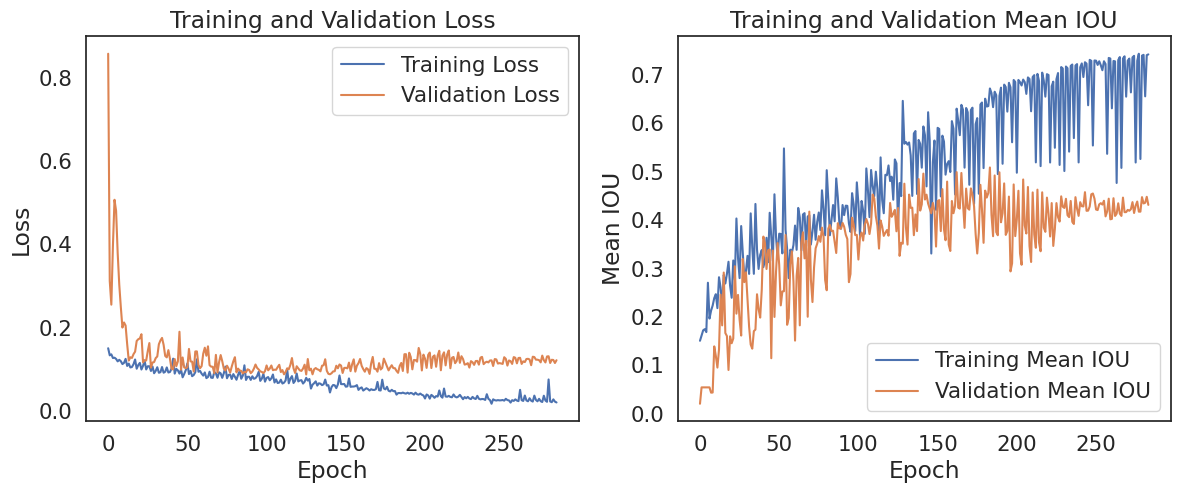

59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9175 - loss: 0.0205 - mean_iou: 0.7225 - val_accuracy: 0.6957 - val_loss: 0.1214 - val_mean_iou: 0.4312 - learning_rate: 1.2500e-04


In [95]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping, reduceLROnPlateau, plot_callback, VizCallback(X_val[100], y_val[100])],
    shuffle = True,
    verbose=1
).history

In [96]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

with strategy.scope():
    # Save the trained model to a file with the accuracy included in the filename
    model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
    model.save(model_filename)

Final validation Mean Intersection Over Union: 50.84%


In [ ]:
cmap = plt.cm.get_cmap('tab10', 5)

# Pick 20 random samples from trainning
random_indices = np.random.choice(len(X_train), 20, replace=False)

# Interpolate the selected masks
selected_masks = y_train[random_indices]
predicted_masks = model.predict(selected_masks)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plot the images, original masks, and interpolated masks
fig, axes = plt.subplots(20, 3, figsize=(15, 50))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(X_train[idx], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {idx}')
    
    axes[i, 1].imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Original Mask {idx}')
    
    axes[i, 2].imshow(predicted_masks[i], cmap=cmap, vmin=0, vmax=4)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Predicted Mask {idx}')

# Create a legend for the labels
labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
handles = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(5)]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.show()

In [ ]:
# Pick 10 random samples from trainning
random_indices = np.random.choice(len(X_val), 10, replace=False)

# Interpolate the selected masks
selected_masks = y_val[random_indices]
predicted_masks = model.predict(selected_masks)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plot the images, original masks, and interpolated masks
fig, axes = plt.subplots(10, 3, figsize=(15, 50))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(X_val[idx], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {idx}')
    
    axes[i, 1].imshow(y_val[idx], cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Original Mask {idx}')
    
    axes[i, 2].imshow(predicted_masks[i], cmap=cmap, vmin=0, vmax=4)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Predicted Mask {idx}')

# Create a legend for the labels
labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
handles = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(5)]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.show()

## Predict

In [99]:
test_path = "/kaggle/input/marssoil/mars_for_students.npz"

test_data = np.load(test_path)
X_test = test_data["test_set"]

X_test = X_test[..., np.newaxis] / 255.0

print(f"Input shape: {input_shape}")

Input shape: (64, 128, 1)


In [100]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step
Predictions shape: (10022, 64, 128)


In [101]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [102]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)